# Surface Mass Balance: XGB 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

# Set WD
import os
from pyrsistent import v
os.getcwd()
#os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

#### Load KM_L 

In [320]:
df = pd.read_csv('data/promice/preprocessed/daily/SCO_L.csv')

##### Pre-processing

In [321]:
# Fill NA values in Melting season as blank
df['Melting Season'] = df['Melting Season'].fillna('')

In [322]:
#Remove all NA values if training should be done only on ablation
#df = df.dropna()

# Remove only values from Wind direction if training should be done on entire dataset
df = df[df['Wind from direction (upper boom)'].notna()] 

df = df.reset_index(drop=True)

In [323]:
# This bit retrieve the indexes for all melting season categories and remove column from df
for category in ['pre', 'beginning', 'middle', 'end']:
    exec(f"indices_{category} = df[df['Melting Season'] == '{category}'].index")

# This bit retrieve the indexes for Ablation periods
for category in [True]:
    exec(f"indices_ablation = df[df['Ablation'] == {category}].index")

indices_all = df[df['Ablation'].isin([True, False])].index

In [324]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
df['Melting Season'] = le.fit_transform(df['Melting Season'])
dict(zip(le.classes_, le.transform(le.classes_)))

{'': 0, 'beginning': 1, 'end': 2, 'middle': 3, 'pre': 4}

In [325]:
# This bit to include only relevant features
exclude_list = [                                                    'index', # excluded because of unimportant information
                                                                     'stid', # excluded because of unimportant information
                                                               'Unnamed: 0', # Old Index
                                                                 'Ablation',
                                                          # 'Melting Season', # We drop melting season later 
                                              'year', 'month','day', 'hour', # Drop because of sin & cos values
                                                                 'subgroup'
               ]

df = df[[column for column in df.columns if column not in exclude_list]]


In [326]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
    
# This bit to split Datetime column into year, month, day, hour columns
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime'] = df['Datetime'].dt.strftime('%Y-%m-%d')

df['Datetime'] = pd.to_datetime(df['Datetime'])

#Create new columns
#df['year'] = df['Datetime'].dt.year 
df['month'] = df['Datetime'].dt.month
#df['day'] = df['Datetime'].dt.day
#df['hour'] = df['Datetime'].dt.hour

#Drop the datetime column
df.drop(columns=['Datetime'], inplace=True)

In [327]:
# This bit to change the datetime variables into a form that a ML models can understand (continued)
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html 

# Use CyclicalFeatures Package to convert year, month, day & hour
from feature_engine.creation import CyclicalFeatures

cyclical = CyclicalFeatures(variables=None, drop_original=True)

# with year
#cyclical = cyclical.fit_transform(df[['month', 'year', 'Wind from direction (upper boom)']]) 

# without year
cyclical = cyclical.fit_transform(df[['month', 'Wind from direction (upper boom)']]) 
df = pd.merge(df, cyclical, left_index=True, right_index=True)

df.drop(columns=['month', 'Wind from direction (upper boom)'], inplace=True)

In [328]:
# This bit to convert all numerical values into the same scale 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# with year
#num_cols = df.select_dtypes(include=['int64','float64']).drop(['Surface height from combined measurements', 'Surface height from combined measurements DELTA','month_sin','month_cos','year_sin','year_cos','Wind from direction (upper boom)_sin', 'Wind from direction (upper boom)_cos', 'Melting Season'], axis=1).columns #select numerical columns except y and cyclical feature

# without year
num_cols = df.select_dtypes(include=['int64','float64']).drop(['Surface height from combined measurements', 'Surface height from combined measurements DELTA','month_sin','month_cos','Wind from direction (upper boom)_sin', 'Wind from direction (upper boom)_cos', 'Melting Season'], axis=1).columns #select numerical columns except y and cyclical feature

scaler = MinMaxScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])

In [329]:
# This bit to split into Train & Test
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# split the data into training and testing sets while maintaining the subgroup distribution
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

### Delta ###
df_delta = df[[column for column in df.columns if column not in ["Surface height from combined measurements"]]]

for train_index, test_index in split.split(df_delta, df_delta['Melting Season']):
    delta_train = df_delta.loc[train_index]
    delta_test = df_delta.loc[test_index]

# separate the features and target variables for the train and test sets
X_delta_train = delta_train.drop(['Surface height from combined measurements DELTA', 'Melting Season'], axis=1)
y_delta_train = delta_train['Surface height from combined measurements DELTA']
X_delta_test = delta_test.drop(['Surface height from combined measurements DELTA', 'Melting Season'], axis=1)
y_delta_test = delta_test['Surface height from combined measurements DELTA']

### Absolute ###
df_absolute = df[[column for column in df.columns if column not in ["Surface height from combined measurements DELTA"]]]

for train_index, test_index in split.split(df_absolute, df_absolute['Melting Season']):
    absolute_train = df_absolute.loc[train_index]
    absolute_test = df_absolute.loc[test_index]

# separate the features and target variables for the train and test sets
X_absolute_train = absolute_train.drop(['Surface height from combined measurements', 'Melting Season'], axis=1)
y_absolute_train = absolute_train['Surface height from combined measurements']
X_absolute_test = absolute_test.drop(['Surface height from combined measurements', 'Melting Season'], axis=1)
y_absolute_test = absolute_test['Surface height from combined measurements']


## XGB Regression

In [330]:
# Import required libraries
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [331]:
# This bit to find best XBG Regressor model for when Ablation == True and for both target variables

for i in ["delta","absolute"]:
    
    indices = eval(f"indices_ablation")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(eval(f"X_{i}_train").index)
    y_Train_valid_indices = indices.intersection(eval(f"y_{i}_train").index)
    X_Test_valid_indices = indices.intersection(eval(f"X_{i}_test").index)
    y_Test_valid_indices = indices.intersection(eval(f"y_{i}_test").index)

    # filter out by indeces
    X_train_category = eval(f"X_{i}_train").loc[X_Train_valid_indices]  
    y_train_category = eval(f"y_{i}_train").loc[y_Train_valid_indices] 
    X_test_category = eval(f"X_{i}_test").loc[X_Test_valid_indices]  
    y_test_category = eval(f"y_{i}_test").loc[y_Test_valid_indices]
    
    # Define the XGBRegressor model
    #model = xgb.XGBRegressor()
    exec(f"model_{i} = xgb.XGBRegressor()")
    
    # Define the hyperparameter grid for tuning
    param_grid = {
        'max_depth': [7], #[3, 5, 7],
        'min_child_weight': [5], #[1, 3, 5],
        'learning_rate': [0.1], #[0.1, 0.01, 0.001],
        'n_estimators': [100], #[100, 500, 1000],
        'subsample': [0.5], #[0.5, 0.7, 1.0],
        'colsample_bytree': [0.7], #[0.5, 0.7, 1.0],
        'reg_alpha': [0.5], #[0, 0.1, 0.5],
        'reg_lambda': [0.1], #[0, 0.1, 0.5]
    }

    # Define the grid search object
    grid_search = GridSearchCV(eval(f"model_{i}"), param_grid = param_grid, cv=5, n_jobs=-1, verbose=0)

    # Fit the grid search object to the training data
    grid_search.fit(X_train_category, y_train_category)
    
    # Print the best hyperparameters and the corresponding R^2 score on the test set
    print(f"Best hyperparameters_{i}: ", grid_search.best_params_)
    
    # Save the best model parameters as 'model' variable
    exec(f"model_{i} = grid_search.best_estimator_")
    
    # Evaluate the best model on the test set
    y_pred_category = eval(f"model_{i}").predict(X_test_category)
    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({i}): ", r2)
    print(f"MSE on test set ({i}): ", mse)

Best hyperparameters_delta:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
R^2 score on test set (delta):  -0.05373747504274706
MSE on test set (delta):  0.005467181679866473
Best hyperparameters_absolute:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
R^2 score on test set (absolute):  0.708741544531475
MSE on test set (absolute):  35.50152243918178


In [300]:
# This bit to see output of the best delta model

indices = eval(f"indices_ablation")

# Find common indexes
X_Test_valid_indices = indices.intersection(X_delta_test.index)
y_Test_valid_indices = indices.intersection(y_delta_test.index)

# filter out by indeces
X_test_category = X_delta_test.loc[X_Test_valid_indices]  
y_test_category = y_delta_test.loc[y_Test_valid_indices]

y_pred_category = model_delta.predict(X_test_category)
r2 = r2_score(y_test_category, y_pred_category)
mse = mean_squared_error(y_test_category, y_pred_category)
print(f"R^2 score on test set: ", r2)
print(f"MSE on test set: ", mse)

R^2 score on test set:  0.011953598537808308
MSE on test set:  0.00754513635027364


In [301]:
# This bit to see output of the best absolute model

indices = eval(f"indices_ablation")

# Find common indexes
X_Test_valid_indices = indices.intersection(X_absolute_test.index)
y_Test_valid_indices = indices.intersection(y_absolute_test.index)

# filter out by indeces
X_test_category = X_absolute_test.loc[X_Test_valid_indices]  
y_test_category = y_absolute_test.loc[y_Test_valid_indices]

y_pred_category = model_absolute.predict(X_test_category)
r2 = r2_score(y_test_category, y_pred_category)
mse = mean_squared_error(y_test_category, y_pred_category)
print(f"R^2 score on test set: ", r2)
print(f"MSE on test set: ", mse)

R^2 score on test set:  0.5662573692929682
MSE on test set:  53.729194137691465


## Filter by Melting Season

R^2 score on test set (pre):  -0.10010786613779765
MSE on test set (pre):  0.02078708645795318
                                        Feature  Importance
0                                        Albedo    0.091702
1          Wind from direction (upper boom)_cos    0.072500
2    Relative humidity (upper boom) - corrected    0.072396
3                  Air temperature (upper boom)    0.070787
4     Upwelling shortwave radiation - corrected    0.070433
5                                   Cloud cover    0.068653
6                           Surface temperature    0.068571
7          Wind from direction (upper boom)_sin    0.059099
8                Downwelling longwave radiation    0.057971
9                       Wind speed (upper boom)    0.053678
10                 Upwelling longwave radiation    0.053452
11                    Air pressure (upper boom)    0.052660
12  Downwelling shortwave radiation - corrected    0.047214
13              Sensible heat flux (upper boom)    0.047076
14   

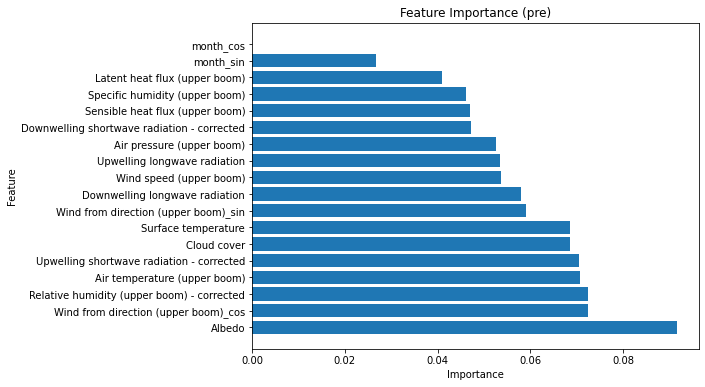

R^2 score on test set (beginning):  -21.075661144249697
MSE on test set (beginning):  0.024889224662717917
                                        Feature  Importance
0     Upwelling shortwave radiation - corrected    0.192825
1                                        Albedo    0.178454
2                Specific humidity (upper boom)    0.097872
3                Downwelling longwave radiation    0.093152
4                  Air temperature (upper boom)    0.090185
5                     Air pressure (upper boom)    0.057358
6                           Surface temperature    0.056460
7                 Latent heat flux (upper boom)    0.049985
8                  Upwelling longwave radiation    0.048868
9               Sensible heat flux (upper boom)    0.039908
10                                  Cloud cover    0.027727
11         Wind from direction (upper boom)_cos    0.021170
12  Downwelling shortwave radiation - corrected    0.020296
13         Wind from direction (upper boom)_sin    0.

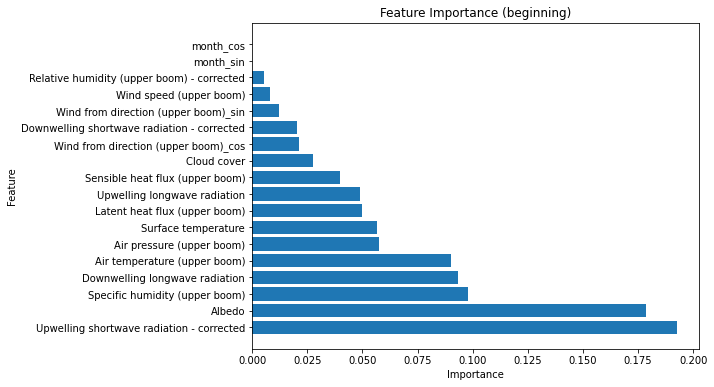

R^2 score on test set (middle):  0.37455079938030555
MSE on test set (middle):  0.00039807196050844535
                                        Feature  Importance
0                  Upwelling longwave radiation    0.128616
1                     Air pressure (upper boom)    0.106980
2                  Air temperature (upper boom)    0.098105
3                                     month_sin    0.089207
4                                        Albedo    0.089006
5                                     month_cos    0.066756
6                 Latent heat flux (upper boom)    0.054056
7                           Surface temperature    0.051957
8   Downwelling shortwave radiation - corrected    0.050800
9                Specific humidity (upper boom)    0.050682
10              Sensible heat flux (upper boom)    0.040283
11    Upwelling shortwave radiation - corrected    0.039521
12               Downwelling longwave radiation    0.030954
13                                  Cloud cover    0.0308

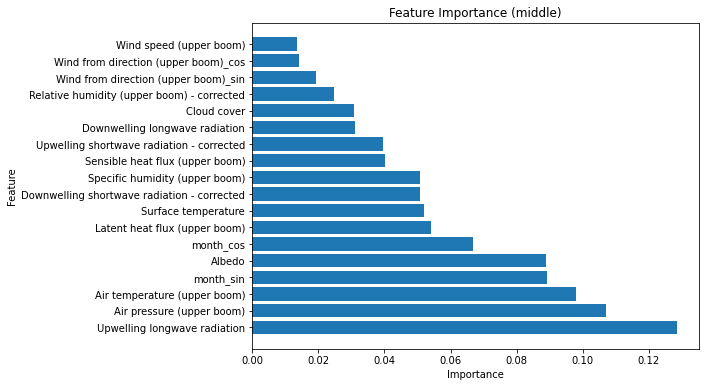

R^2 score on test set (end):  0.011268937314836025
MSE on test set (end):  0.3274781941499637
                                        Feature  Importance
0                  Air temperature (upper boom)    0.374193
1                                        Albedo    0.095631
2                Downwelling longwave radiation    0.093575
3                  Upwelling longwave radiation    0.069530
4    Relative humidity (upper boom) - corrected    0.061624
5                Specific humidity (upper boom)    0.055406
6                     Air pressure (upper boom)    0.051452
7     Upwelling shortwave radiation - corrected    0.044835
8                                   Cloud cover    0.044761
9          Wind from direction (upper boom)_sin    0.037528
10                Latent heat flux (upper boom)    0.022370
11              Sensible heat flux (upper boom)    0.016520
12  Downwelling shortwave radiation - corrected    0.012621
13                      Wind speed (upper boom)    0.010184
14    

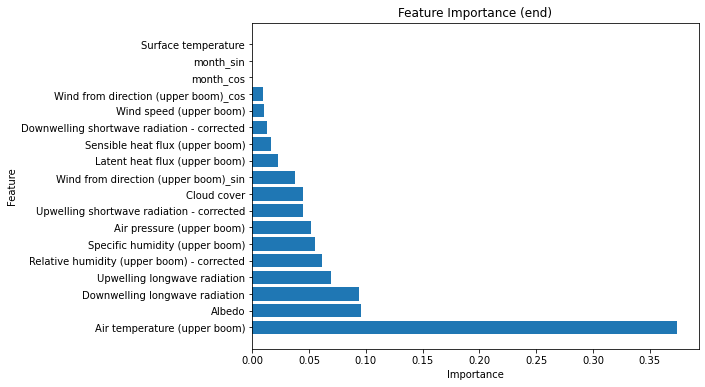

In [318]:
### This bit for delta
for category in ['pre', 'beginning', 'middle', 'end']:
    indices = eval(f"indices_{category}")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(X_delta_train.index)
    y_Train_valid_indices = indices.intersection(y_delta_train.index)
    X_Test_valid_indices = indices.intersection(X_delta_test.index)
    y_Test_valid_indices = indices.intersection(y_delta_test.index)

    # filter out by indeces
    X_train_category = X_delta_train.loc[X_Train_valid_indices]
    y_train_category = y_delta_train.loc[y_Train_valid_indices]
    X_test_category = X_delta_test.loc[X_Test_valid_indices]
    y_test_category = y_delta_test.loc[y_Test_valid_indices]

    # Apply XGB on all periods  
    model_delta.fit(X_train_category, y_train_category)  # Fit a new model on each subset
    y_pred_category = model_delta.predict(X_test_category)

    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({category}): ", r2)
    print(f"MSE on test set ({category}): ", mse)

    # Get the feature importance scores and plot them
    feature_importance = pd.DataFrame({'Feature': X_delta_train.columns, 'Importance': model_delta.feature_importances_})
    feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
    print(feature_importance)

    # Plot the feature importance scores
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance ({category})')
    plt.show()


R^2 score on test set (pre):  0.569397596162925
MSE on test set (pre):  45.53958162281169
                                        Feature  Importance
0          Wind from direction (upper boom)_sin    0.120889
1          Wind from direction (upper boom)_cos    0.108344
2                                        Albedo    0.069715
3                                     month_cos    0.068451
4    Relative humidity (upper boom) - corrected    0.057720
5                                   Cloud cover    0.057489
6                       Wind speed (upper boom)    0.053971
7               Sensible heat flux (upper boom)    0.053018
8                 Latent heat flux (upper boom)    0.052546
9   Downwelling shortwave radiation - corrected    0.051074
10               Specific humidity (upper boom)    0.042760
11                          Surface temperature    0.042431
12                 Upwelling longwave radiation    0.041770
13                 Air temperature (upper boom)    0.040079
14        

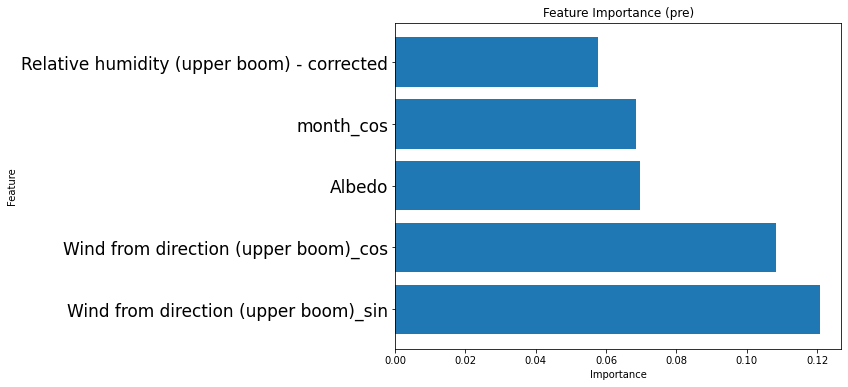

R^2 score on test set (beginning):  0.6724282663786637
MSE on test set (beginning):  40.20525332616008
                                        Feature  Importance
0                                        Albedo    0.186737
1   Downwelling shortwave radiation - corrected    0.098746
2          Wind from direction (upper boom)_sin    0.097035
3                                   Cloud cover    0.080256
4                           Surface temperature    0.074144
5                Specific humidity (upper boom)    0.066789
6          Wind from direction (upper boom)_cos    0.063062
7                 Latent heat flux (upper boom)    0.048925
8                     Air pressure (upper boom)    0.045581
9    Relative humidity (upper boom) - corrected    0.040305
10                 Air temperature (upper boom)    0.040228
11               Downwelling longwave radiation    0.034465
12                 Upwelling longwave radiation    0.032567
13    Upwelling shortwave radiation - corrected    0.0321

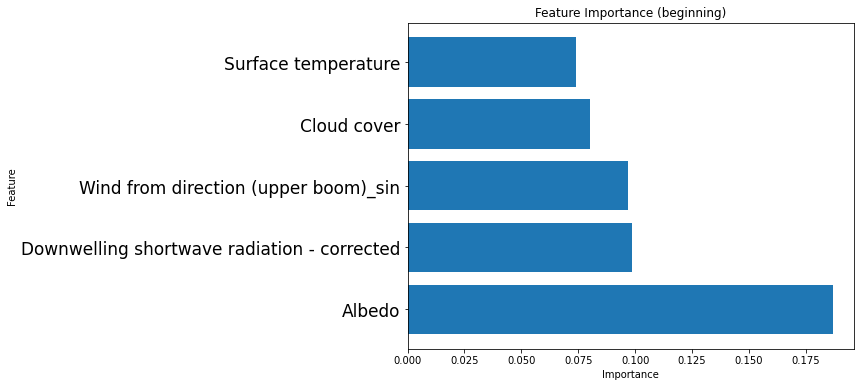

R^2 score on test set (middle):  0.7202749185774434
MSE on test set (middle):  33.04269063445042
                                        Feature  Importance
0                                        Albedo    0.190334
1          Wind from direction (upper boom)_sin    0.118644
2                           Surface temperature    0.115237
3                Specific humidity (upper boom)    0.094010
4                 Latent heat flux (upper boom)    0.056172
5                  Air temperature (upper boom)    0.055330
6                  Upwelling longwave radiation    0.046046
7               Sensible heat flux (upper boom)    0.045531
8                       Wind speed (upper boom)    0.037630
9          Wind from direction (upper boom)_cos    0.036726
10                                  Cloud cover    0.035066
11  Downwelling shortwave radiation - corrected    0.032558
12               Downwelling longwave radiation    0.025805
13                                    month_cos    0.025314
14 

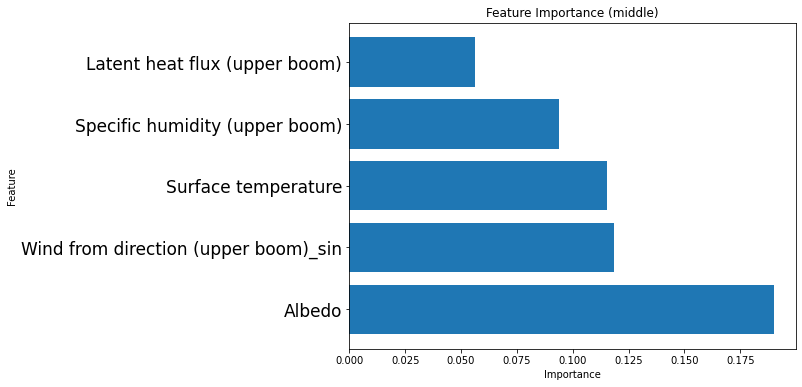

R^2 score on test set (end):  0.5936045762348494
MSE on test set (end):  54.79248492127238
                                        Feature  Importance
0                                     month_cos    0.280688
1                                        Albedo    0.106085
2          Wind from direction (upper boom)_sin    0.102561
3   Downwelling shortwave radiation - corrected    0.067274
4                                     month_sin    0.049428
5                       Wind speed (upper boom)    0.044933
6                           Surface temperature    0.036494
7    Relative humidity (upper boom) - corrected    0.036416
8                Downwelling longwave radiation    0.036146
9          Wind from direction (upper boom)_cos    0.033258
10                 Air temperature (upper boom)    0.032873
11               Specific humidity (upper boom)    0.028115
12                    Air pressure (upper boom)    0.027612
13                 Upwelling longwave radiation    0.027235
14    Upw

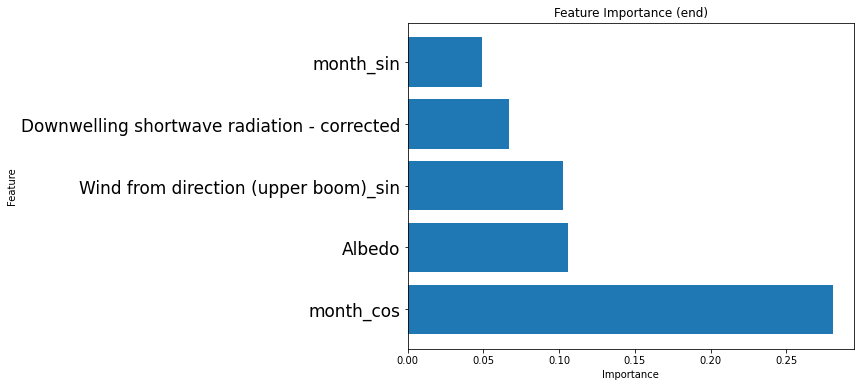

In [335]:
### This bit for absolute
for category in ['pre', 'beginning', 'middle', 'end']:
    indices = eval(f"indices_{category}")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(X_absolute_train.index)
    y_Train_valid_indices = indices.intersection(y_absolute_train.index)
    X_Test_valid_indices = indices.intersection(X_absolute_test.index)
    y_Test_valid_indices = indices.intersection(y_absolute_test.index)

    # filter out by indeces
    X_train_category = X_absolute_train.loc[X_Train_valid_indices]
    y_train_category = y_absolute_train.loc[y_Train_valid_indices]
    X_test_category = X_absolute_test.loc[X_Test_valid_indices]
    y_test_category = y_absolute_test.loc[y_Test_valid_indices]

    # Apply XGB on all periods  
    model_absolute.fit(X_train_category, y_train_category)  # Fit a new model on each subset
    y_pred_category = model_absolute.predict(X_test_category)

    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({category}): ", r2)
    print(f"MSE on test set ({category}): ", mse)

    # Get the feature importance scores and plot them
    feature_importance = pd.DataFrame({'Feature': X_absolute_train.columns, 'Importance': model_absolute.feature_importances_})
    feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
    print(feature_importance)
    feature_importance = feature_importance.head(5)

    # Plot the feature importance scores
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance ({category})')
    plt.yticks(fontsize=17)  
    plt.show()


-----------

## LSTM

In [313]:
# This bit to find best LSTM model for when Ablation == True and for both target variables

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

for i in ["delta","absolute"]:
    
    indices = eval(f"indices_ablation")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(eval(f"X_{i}_train").index)
    y_Train_valid_indices = indices.intersection(eval(f"y_{i}_train").index)
    X_Test_valid_indices = indices.intersection(eval(f"X_{i}_test").index)
    y_Test_valid_indices = indices.intersection(eval(f"y_{i}_test").index)

    # filter out by indeces
    X_train_category = eval(f"X_{i}_train").loc[X_Train_valid_indices]  
    y_train_category = eval(f"y_{i}_train").loc[y_Train_valid_indices] 
    X_test_category = eval(f"X_{i}_test").loc[X_Test_valid_indices]  
    y_test_category = eval(f"y_{i}_test").loc[y_Test_valid_indices]
    
    # Impute missing values
    X_train_category = X_train_category.fillna(X_train_category.mean())
    y_train_category = y_train_category.fillna(y_train_category.mean())
    X_test_category = X_test_category.fillna(X_test_category.mean())

    
    # Reshape the input data to 3D array
    X_train_category = X_train_category.values.reshape((X_train_category.shape[0], 1, X_train_category.shape[1]))
    X_test_category = X_test_category.values.reshape((X_test_category.shape[0], 1, X_test_category.shape[1]))
    
    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(64, input_shape=(1, X_train_category.shape[2])))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(loss='mse', optimizer='adam')
    
    # Fit the model to the training data
    model.fit(X_train_category, y_train_category, epochs=50, batch_size=64, validation_data=(X_test_category, y_test_category), verbose=0)
    
    # Evaluate the model on the test set
    y_pred_category = model.predict(X_test_category)
    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({i}): ", r2)
    print(f"MSE on test set ({i}): ", mse)


R^2 score on test set (delta):  -0.10340557736615308
MSE on test set (delta):  0.0038937158256251167
R^2 score on test set (absolute):  0.013685247670754519
MSE on test set (absolute):  157.86584193346172


--------